# Analysis Notebook for Raytune Results

### 1. Functions & Things

In [1]:
import pickle as pkl, numpy as np
import numpy as np
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sys

import contextualized
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from contextualized.dags.graph_utils import simulate_linear_sem, is_dag
from contextualized.baselines import (
    BayesianNetwork,
    GroupedNetworks,
)
from contextualized.easy import ContextualizedBayesianNetworks
import pickle as pkl
import os
import numpy

from ray import tune
import logging
import functools
from ray.tune.schedulers import HyperBandScheduler

def measure_mses(betas, X, individual_preds=False):
    """
    Measure mean-squared errors.
    """
    mses = np.zeros((len(betas), len(X)))  # n_bootstraps x n_samples
    for bootstrap in range(len(betas)):
        for target_feat in range(X.shape[-1]):
            # betas are n_boostraps x n_samples x n_features x n_features
            # preds[bootstrap, sample, i] = X[sample, :].dot(betas[bootstrap, sample, i, :])
            preds = np.array(
                [
                    X[sample].dot(betas[bootstrap, sample, :, target_feat])  # + mus[bootstrap, j, i]
                    for sample in range(len(X))
                ]
            )
            residuals = X[:, target_feat] - preds
            mses[bootstrap, :] += residuals**2 / (X.shape[-1])
    if not individual_preds:
        mses = np.mean(mses, axis=0)
    return mses

def measure_recovery(W_true, W):
    # Assumes W has a prefix dimension for bootstraps
    recovery_errs = []
    for bootstrap in range(len(W)):
        for sample in range(len(W[bootstrap])):
            recovery_errs.append(np.linalg.norm(W_true[sample] - W[bootstrap][sample], ord=2))
    return np.mean([recovery_errs])

def make_dag(p, n_nonempty=4):
    # # n_nonempty = number of non-empty cells in W
    # coeffs = [np.random.choice([np.random.uniform(-1,-0.5), np.random.uniform(0.5,1)]) for i in range(n_nonempty)]
    # c * coeffs[assign_c_idx.index((i,j))]
    #create upper triangular
    tuples = [(i, j) for i in range(p) for j in range(p) if i < j]
    
    #randomly flip to account for monodirectinality
    tuples = [(t[1],t[0]) if np.random.uniform(0,1) > 0.5 else t for t in tuples]

    #select n_nonempty
    assign_c_idx = random.sample(tuples, n_nonempty)

    w = np.zeros((p, p))

    for i in range(p):
        for j in range(p):
            if (i,j) in assign_c_idx:
                w[i, j] = 1
                # w[0, 1] = 1
                # w[2, 1] = 1
                # w[3, 1] = 1
                # w[3, 2] = 1
    if is_dag(w):
        return w
    else:
        return make_dag(p, n_nonempty)

def generate_WC(p, n, n_clusters = 5, mode='linear'):
    '''Generate W and C for a given p, n, and mode.'''

    W = np.zeros((n, p, p))
    
    if mode == 'cluster':
        
        C = np.zeros((n, 1))
        cs = [np.random.normal(0, 1) for i in range(n_clusters)]
        centroid_ws = []
        for i in range(n_clusters):
            centroid_ws.append(make_dag(p))

        for i in range(n):
            c_idx = np.random.choice(len(centroid_ws))
            masked_std = np.random.normal(0, 0.2, size=(p, p)) * (centroid_ws[c_idx] != 0)            
            W[i] = centroid_ws[c_idx] + masked_std
            C[i,0] = c_idx

    elif mode == 'linear':
        dag = make_dag(p)

        C = np.random.normal(0, 1, size=(n, 1))
        coeffs = [np.random.choice([np.random.uniform(-1,-0.5), np.random.uniform(0.5,1)]) for i in range(int(dag.sum()))]
        
        for i in range(n):
            #Each non-empty = c * coeffs[assign_c_idx.index((i,j))]
            assign_c_idx = [(i,j) for i in range(p) for j in range(p) if dag[i,j] == 1]
            for j in range(len(assign_c_idx)):
                W[i, assign_c_idx[j][0], assign_c_idx[j][1]] = C[i,0] * coeffs[j]

    else:
        assert "Error, mode must be 'cluster' or 'linear'"
    
    return W, C
import ray


ray.init(
    num_cpus=1,
    # resources={"cpu":1,'object_store_memory':2*1024*1024*1024},
    # memory=2*1024*1024*1024,
    object_store_memory=2*1024*1024*1024,
    log_to_driver=False,

    # resources={"cpu":1,'object_store_memory':2*1024*1024*1024},
)

logging.getLogger("ray.tune").setLevel(logging.WARNING)



/Users/wtlo/miniconda3/envs/music_env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/wtlo/miniconda3/envs/music_env/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <320D718F-E2FD-3687-B2F0-E83CF97743B1> /Users/wtlo/miniconda3/envs/music_env/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <ADB29998-4917-3D35-B2A2-77968871B420> /Users/wtlo/miniconda3/envs/music_env/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
2023-05-19 08:52:51,919	INFO worker.py:1553 -- Started a local Ray instance.


### 2. Parse Results for here

In [5]:
import pickle as pkl
import numpy as np
import pandas as pd
import os

def get_data_info():
    
    n_data_gens = 1
    ns = [100, 1000]
    ps = [4, 10]
    W_mode = ['cluster', 'linear']
    data_info = {}
    graph_types = ["gauss", "exp", "gumbel", "uniform", "logistic", "poisson"]
    n_clusters = 5
    d_index = 0
    for n in ns:
        for p in ps:
            for w in W_mode:
                for data_gen in range(n_data_gens):
                    data_info[d_index] = {
                        'd_index': d_index,
                        "n": n,
                        "p": p,
                        "W_mode": w,
                        "data_gen": data_gen,
                        'graph_type': 'uniform',
                        'n_clusters': 5,
                        'n_nonempty': 4,
                        'noise_level': 0.5,
                    }
                    d_index += 1
    return data_info

#import test train split of sklearn
from sklearn.model_selection import train_test_split


def read_data(tune_dir='data_noiseless_2'):
    data_info = get_data_info()
    print(data_info.keys())
    
    data = []

    n_fit_iters = 3
    losses = ["NOTEARS", "DAGMA", "poly"]
    encoder_types = ['ngam', 'mlp']
    ks = [4, 8, 16]

    stratify_by = {
        'loss_type': losses,
        'encoder_types': encoder_types,
        'ks':ks
    }
    
    datas = pkl.load(open(f"{tune_dir}/{tune_dir}_data.pkl", 'rb'))
    
    #dataset is rows
    rows = []
    avg_rows = []


    for d_index, d in enumerate(datas):
        print(d_index)
        continue
        
        if d_index == 2: break
        for strat in stratify_by.keys():
            
            from ray.tune.schedulers import ASHAScheduler
            from ray.tune import CLIReporter
            from ray.air import RunConfig

            for instance in stratify_by[strat]:
                # if strat == 'ks':
                #     config['n_factors'] = tune.sample_from(lambda spec: int(np.random.randint(0,instance)))
                # n_runs = 4
                mses = []
                recoveries = []
                pop_mses = []
                pop_recoveries = []
                cluster_mses = []
                cluster_recoveries = []
                
                recovery_train = lambda W_pred: measure_recovery(W_train, W_pred)
                recovery_test = lambda W_pred: measure_recovery(W_test, W_pred)
                mse_train = lambda W_pred: np.mean(measure_mses(W_pred, X_train))
                mse_test = lambda W_pred: np.mean(measure_mses(W_pred, X_test))
                results_string = lambda W_pred_train, W_pred_test: f", {recovery_train(W_pred_train)}, {recovery_test(W_pred_test)}, {mse_train(W_pred_train)}, {mse_test(W_pred_test)}"
                
                for i in range(n_fit_iters):
                    
                    C,X,W = d
                    C_train, C_test, X_train, X_test, W_train, W_test = train_test_split(C, X, W, test_size=0.3)
                    # dag = BayesianNetwork().fit(X_train, max_epochs=100)
                    # pop_preds_train = np.expand_dims(dag.predict(len(X_train)), 0)
                    # pop_preds_test  = np.expand_dims(dag.predict(len(X_test)), 0)
                    
                    # pop_mse = mse_test(pop_preds_test)
                    # pop_recovery = recovery_test(pop_preds_test)

                    # km = KMeans(n_clusters=4)
                    # km.fit(C)
                    # cluster_dag = GroupedNetworks(BayesianNetwork).fit(X_train, km.predict(C_train))
                    # cluster_preds_train = np.expand_dims(cluster_dag.predict(km.predict(C_train)), 0)
                    # cluster_preds_test = np.expand_dims(cluster_dag.predict(km.predict(C_test)), 0)
                    
                    # cluster_mse = mse_test(cluster_preds_test)
                    # cluster_recovery = recovery_test(cluster_preds_test)

                    if os.path.exists(f'{tune_dir}/tune_analysis_d{d_index}_s{strat}_ins{instance}_i{i}.pickle'):
                        with open(f'{tune_dir}/tune_analysis_d{d_index}_s{strat}_ins{instance}_i{i}.pickle', 'rb') as handle:
                            r = pkl.load(handle)
                            results = r.get_best_result()
                            # print(dir(results))
                            import seaborn as sns
                            sns.lineplot(r.get_dataframe()['test_mse'])
                            sns.lineplot(r.get_dataframe()['test_recovery'])
                            plt.show()
                            # fdsa
                            # print(results.get_dataframe.describe())
                    else:
                        df_avg = pd.DataFrame(avg_rows, columns=list(data_info[0].keys()) + ['strat', 'instance', 'mse', 'recovery'])
                        df_full = pd.DataFrame(rows, columns=list(data_info[0].keys()) + ['strat', 'instance', 'mse', 'recovery', 'hyperparameters'])
                        df_avg.to_csv(f'{tune_dir}/df_avg.csv')
                        df_full.to_csv(f'{tune_dir}/df_full.csv')
                        fdsa
                    print(r.get_dataframe().describe())
                    fdsa
                    mse = results.metrics['test_mse']
                    recovery = results.metrics['test_recovery']
                    hps = results.metrics['experiment_tag']
                    mses.append(mse)
                    recoveries.append(recovery)
                    
                    rows.append(list(data_info[d_index].values()) + [strat, instance, mse, recovery, hps])
                avg_rows.append(list(data_info[d_index].values()) + [strat, instance, np.mean(mses), np.mean(recoveries)])
            
            # config = {
            #     "loss_type": tune.choice(losses),
            #     "encoder_types": tune.choice(encoder_types),
            #     'use_dynamic_alpha_rho': tune.choice([True, False]),
            #     "ks": tune.choice(ks),
            #     "n_factors": tune.sample_from(lambda spec: int(np.random.randint(0,spec.config.ks))),
            #     "alpha": tune.uniform(0.001, 0.1),
            #     "rho": tune.uniform(0.001, 0.1),
            #     "s": tune.uniform(0.001, 5),
            # }
    # df_avg = pd.DataFrame(avg_rows, columns=list(data_info[0].keys()) + ['strat', 'instance', 'mse', 'recovery'])
    # df_full = pd.DataFrame(rows, columns=list(data_info[0].keys()) + ['strat', 'instance', 'mse', 'recovery'])
    # df_avg.to_csv(f'{tune_dir}/df_avg.csv')
    # df_full.to_csv(f'{tune_dir}/df_full.csv')

read_data(tune_dir='data_updated')


# datas = get_data()
# datas = pkl.load(open("data2/data2.pkl", 'rb'))
# print(len(datas))



dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
8
0
1
2
3
4
5
6
7


### Updated version

In [ ]:
import pickle as pkl
import numpy as np
import pandas as pd
import os

def get_data_info():
    n_data_gens = 2
    ns = [100, 1000]
    ps = [4, 10]
    W_mode = ['cluster', 'linear']
    data_info = {}
    graph_types = ["gauss", "exp", "gumbel", "uniform", "logistic", "poisson"]
    n_clusters = 5
    d_index = 0
    for n in ns:
        for p in ps:
            for w in W_mode:
                for data_gen in range(n_data_gens):
                    data_info[d_index] = {
                        'd_index': d_index,
                        "n": n,
                        "p": p,
                        "W_mode": w,
                        "data_gen": data_gen,
                        'graph_type': 'uniform',
                        'n_clusters': 5,
                        'n_nonempty': 4,
                        'noise_level': 0.5,
                    }
                    d_index += 1
    return data_info

#import test train split of sklearn
from sklearn.model_selection import train_test_split


def train_pop_clust(tune_dir='data_noiseless', train_population=False):
    data_info = get_data_info()

    data = []

    n_fit_iters = 3 
    losses = ["NOTEARS", "DAGMA", "poly"]
    encoder_types = ['ngam', 'mlp']
    ks = [4, 8, 16]

    stratify_by = {
        'loss_type': losses,
        'encoder_types': encoder_types,
        'ks':ks
    }
    
    #load same data
    datas = pkl.load(open(f"data_noiseless/data_noiseless.pkl", 'rb'))
    
    #dataset is rows
    rows = []
    avg_rows = []
 
    for d_index, d in enumerate(datas):
        if d_index >= 16: break
        pop_mses = []
        pop_recoveries = []
        cluster_mses = []
        cluster_recoveries = []
        
        recovery_train = lambda W_pred: measure_recovery(W_train, W_pred)
        recovery_test = lambda W_pred: measure_recovery(W_test, W_pred)
        mse_train = lambda W_pred: np.mean(measure_mses(W_pred, X_train))
        mse_test = lambda W_pred: np.mean(measure_mses(W_pred, X_test))
        results_string = lambda W_pred_train, W_pred_test: f", {recovery_train(W_pred_train)}, {recovery_test(W_pred_test)}, {mse_train(W_pred_train)}, {mse_test(W_pred_test)}"
        
        for run_i in range(n_fit_iters):
            
            C,X,W = d
            C_train, C_test, X_train, X_test, W_train, W_test = train_test_split(C, X, W, test_size=0.3)
            dag = BayesianNetwork().fit(X_train, max_epochs=100)
            pop_preds_train = np.expand_dims(dag.predict(len(X_train)), 0)
            pop_preds_test  = np.expand_dims(dag.predict(len(X_test)), 0)
            
            pop_mse = mse_test(pop_preds_test)
            pop_recovery = recovery_test(pop_preds_test)

            km = KMeans(n_clusters=5)
            km.fit(C)
            cluster_dag = GroupedNetworks(BayesianNetwork).fit(X_train, km.predict(C_train))
            cluster_preds_train = np.expand_dims(cluster_dag.predict(km.predict(C_train)), 0)
            cluster_preds_test = np.expand_dims(cluster_dag.predict(km.predict(C_test)), 0)
            
            cluster_mse = mse_test(cluster_preds_test)
            cluster_recovery = recovery_test(cluster_preds_test)
            
            pop_mses.append(pop_mse)
            pop_recoveries.append(pop_recovery)
            cluster_mses.append(cluster_mse)
            cluster_recoveries.append(cluster_recovery)

            cols = list(data_info[d_index].values()) + [run_i]
            cols += [pop_mse, pop_recovery, cluster_mse, cluster_recovery] #performance metrics
            rows.append(cols)
        
        avg_cols = list(data_info[d_index].values())
        avg_cols += [np.mean(pop_mse), np.mean(pop_recovery), np.mean(cluster_mse), np.mean(cluster_recovery)]
        avg_rows.append(avg_cols)

    col_names_avg = list(data_info[0].keys())
    col_names_avg += ['pop_mse', 'pop_recovery', 'cluster_mse', 'cluster_recovery']
    
    col_names_full = list(data_info[0].keys()) + ['run_i']
    col_names_full += ['pop_mse', 'pop_recovery', 'cluster_mse', 'cluster_recovery']
    
    df_avg = pd.DataFrame(avg_rows, columns=col_names_avg)
    df_full = pd.DataFrame(rows, columns=col_names_full)
    df_avg.to_csv(f'{tune_dir}/df_avg_pop_clust.csv')
    df_full.to_csv(f'{tune_dir}/df_full_pop_clust.csv')

train_pop_clust(train_population=False)

### 4 Load the Data

In [158]:
# df_avg.to_csv('data2/df_avg.csv')
#     df_full.to_csv('data2/df_full.csv')
#read
import pandas as pd
tune_dir = 'data_noiseless'
df_avg = pd.read_csv(f'{tune_dir}/df_avg.csv')
df_full = pd.read_csv(f'{tune_dir}/df_full_renamed.csv')
df_avg_pop_clust = pd.read_csv(f'{tune_dir}/df_avg_pop_clust.csv')
df_full_pop_clust = pd.read_csv(f'{tune_dir}/df_full_pop_clust.csv')


#setup data
losses = ["NOTEARS", "DAGMA", "poly"]
encoder_types = ['ngam', 'mlp']
ks = [4, 8, 16]

model_hps = {
    'loss_type': losses,
    'encoder_types': encoder_types,
    'ks': ks,
}

ns = [100]
ps = [4, 10]
graph_types = ["uniform"] #["gauss", "exp", "gumbel", "uniform", "logistic", "poisson"]
W_mode = ['cluster', 'linear']

data_hps = {
    'n': ns,
    'p': ps,
    'W_mode': W_mode,
}

# df_full = df_full.rename(columns={'hyperparameters': 'recovery', 'mse': 'hyperparameters', 'recovery': 'mse'})
# df_full.to_csv(f'{tune_dir}/df_full_renamed.csv')

### 5 Code to print plots

<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = 

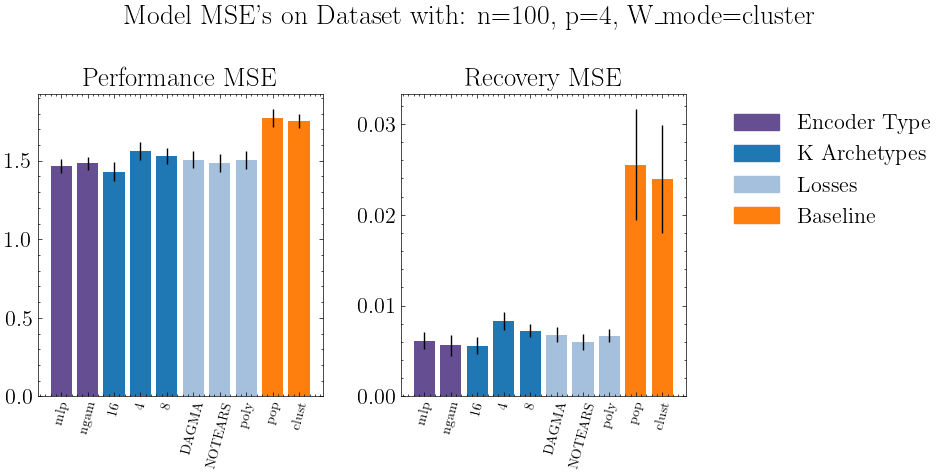

<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = 

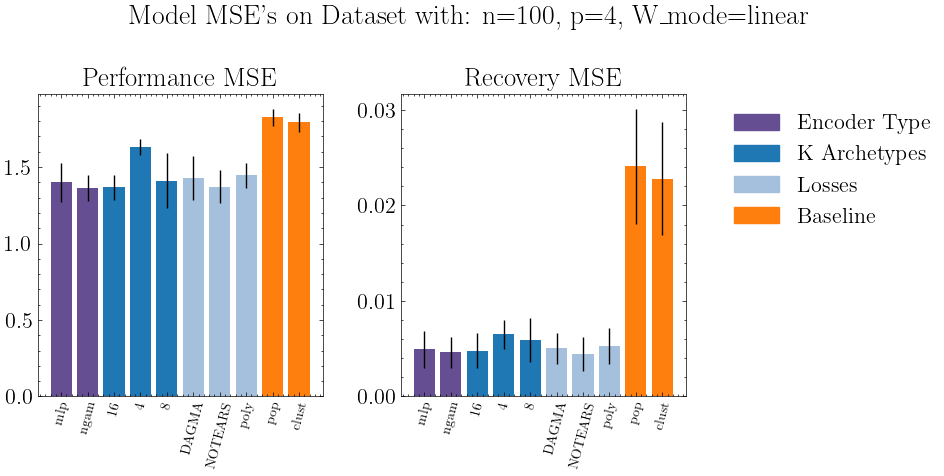

<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = 

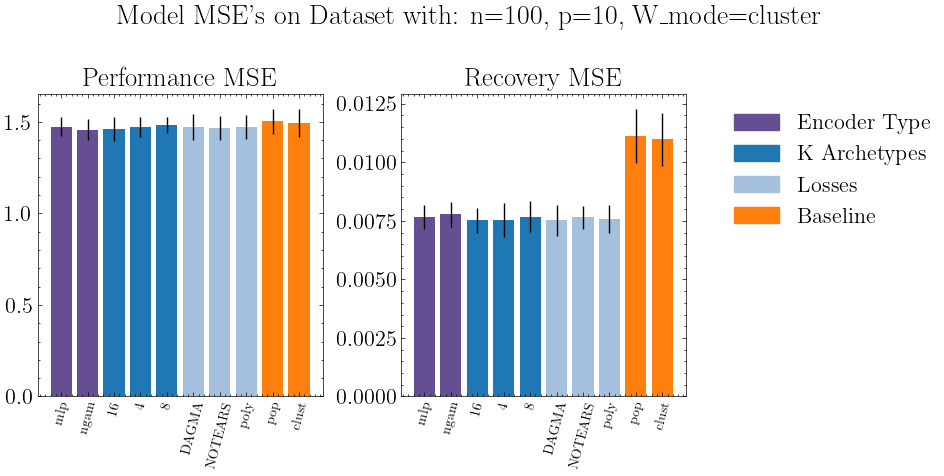

<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = mse.append(mse_tmp)
<ipython-input-161-843930afd888>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  recovery = recovery.append(recovery_tmp)
<ipython-input-161-843930afd888>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse = 

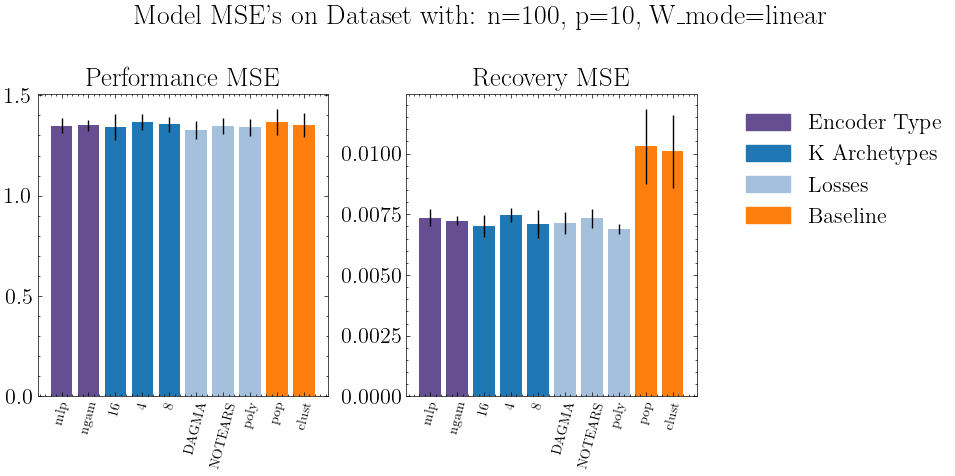

In [161]:

#write a function to get functools product of all the values in the dict
from itertools import product
# print(df_avg.columns)

def get_masked_df(df, hp_iter):
    df = df.copy()
    mask = True#[True] * df.shape[0]
    for k, v in hp_iter.items():
        # print(k,v)
        mask &= df[k] == hp_iter[k]
    return df[mask]

import scienceplots
plt.style.use('science')
from matplotlib.patches import Rectangle

def iter_stuff():
    data_info = []
    #iter through data hps
    for hp_ds_vals in product(*data_hps.values()):
        hp_ds_kvals = dict(zip(data_hps.keys(), hp_ds_vals))
        df_ds_masked = get_masked_df(df_full, hp_ds_kvals)
        df_ds_popclust_masked = get_masked_df(df_full_pop_clust, hp_ds_kvals)

        hp_results = df_ds_masked.groupby(['strat', 'instance'])[['recovery', 'mse']].agg(['mean', 'std'])
        
        #baselines
        pop_recovery_mean = df_ds_popclust_masked['pop_recovery'].mean()
        pop_recovery_std = df_ds_popclust_masked['pop_recovery'].std()
        pop_mse_mean = df_ds_popclust_masked['pop_mse'].mean()
        pop_mse_std = df_ds_popclust_masked['pop_mse'].std()
        
        
        cluster_recovery_mean = df_ds_popclust_masked['cluster_recovery'].mean()
        cluster_recovery_std = df_ds_popclust_masked['cluster_recovery'].std()
        cluster_mse_mean = df_ds_popclust_masked['cluster_mse'].mean()
        cluster_mse_std = df_ds_popclust_masked['cluster_mse'].std()
        
        mse = pd.DataFrame(columns=['class','mean', 'std'], index=['instance'])
        recovery = pd.DataFrame(columns=['class','mean', 'std'], index=['instance'])

        for strat in  hp_results.index.get_level_values('strat').unique():
            df_slice = hp_results[hp_results.index.get_level_values('strat') == strat]
            mse_tmp =  df_slice.groupby(['instance']).mean()['mse']
            mse_tmp['class'] = strat
            mse = mse.append(mse_tmp)
            recovery_tmp =  df_slice.groupby(['instance']).mean()['recovery']
            recovery_tmp['class'] = strat
            recovery = recovery.append(recovery_tmp)
        
        # create a dictionary for the mean and std values of pop and clust
        new_data = {'mean': [cluster_mse_mean, pop_mse_mean], 'std': [cluster_mse_std, pop_mse_std], 'class':2*['baseline']}
        new_df = pd.DataFrame(new_data, index=['pop', 'clust'])
        mse = mse.append(new_df)
        mse= mse.iloc[1:]
        recovery= recovery.iloc[1:]
        
        # create a dictionary for the mean and std values of pop and clust
        new_data = {'mean': [cluster_recovery_mean, pop_recovery_mean], 'std': [cluster_recovery_std, pop_recovery_std], 'class':2*['baseline']}
        new_df = pd.DataFrame(new_data, index=['pop', 'clust'])
        recovery = recovery.append(new_df)

        fig, ax = plt.subplots(ncols=2,figsize=(10, 5))
        fig.suptitle(f'Model MSE\'s on Dataset with: {", ".join([f"{k}={v}" for k,v in hp_ds_kvals.items()])} ', fontsize=20)
        
        #colors
        n_encoders = len(model_hps['encoder_types'])
        n_ks = len(model_hps['ks'])
        n_losses = len(model_hps['loss_type'])

        colors = ['#654E92'] * (n_encoders) \
                    + ['#1f77b4'] * (n_ks) \
                    + ['#A5C0DD'] * (n_losses) \
                    + ['#ff7f0e'] * 2
        
        plt.rcParams.update({'font.size': 16})
        
        #performance axis
        ax[0].set_title(f'Performance MSE',weight='bold')
        ax[0].bar(recovery.index, recovery['mean'], yerr=recovery['std'], color = colors)
        
        #recovery axis
        ax[1].set_title(f'Recovery MSE')
        ax[1].bar(mse.index, mse['mean'], yerr=mse['std'], color = colors)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=75,fontsize=10)
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=75,fontsize=10)
        
        #colors
        #1f77b4
        #6C9BCF blue
        encoders_rect = Rectangle((0, 0), 1, 1, color='#654E92')
        ks_rect = Rectangle((0, 0), 1, 1, color='#1f77b4')
        losses_rect = Rectangle((0, 0), 1, 1, color='#A5C0DD')
        
        baseline_rect = Rectangle((0, 0), 1, 1, color='#ff7f0e')
        handles = [encoders_rect, ks_rect, losses_rect, baseline_rect]
        labels = ['Encoder Type','K Archetypes','Losses','Baseline']
        ax[1].legend(labels=labels,handles=handles, bbox_to_anchor=(1.10, 1))
        plt.tight_layout()
        plt.show()
        plt.close()            
iter_stuff()

In [15]:
# display(pd.read_csv('data_noiseless/df_full_pop_clust.csv'))
# display(pd.read_csv('data_noiseless/df_full.csv'))
# display(pd.read_csv('data_noiseless/df_avg_pop_clust.csv'))
# display(pd.read_csv('data_noiseless/df_avg.csv'))

import functools


# iter database conditions

# iter hp configs under those conditions

# both pop cluster and notmad





AttributeError: module 'functools' has no attribute 'product'

### Show in 3 conditions
- 
- 

In [6]:
#create a parallel coordinates plot for each dataset

def create_plots():
    for d in range(df_avg['d_index'].max()):
        # print(d)
        df_avg_d = df_avg[df_avg['d_index'] == d]
        df_full_d = df_full[df_full['d_index'] == d]

        fig = px.parallel_coordinates(df_avg_d, color="mse",
            dimensions=['n', 'p', 'W_mode', 'data_gen', 'strat', 'instance', 'mse', 'recovery'],
            color_continuous_scale=px.colors.diverging.Tealrose,
            color_continuous_midpoint=2)
        # fig.write_image(f"plots/parallel_coordinates_d{d}.png")

        fig = px.parallel_coordinates(df_full_d, color="mse",
            dimensions=['n', 'p', 'W_mode', 'data_gen', 'strat', 'instance', 'mse', 'recovery', 'hyperparameters'],
            color_continuous_scale=px.colors.diverging.Tealrose,
            color_continuous_midpoint=2)
        # fig.write_image(f"plots/parallel_coordinates_full_d{d}.png")
        fig.close()

print(df_avg)
fdsa

#show results
# print(df_avg.groupby(['strat', 'instance'])['mse'].mean())
# print(df_avg.groupby(['strat', 'instance'])['mse'].mean())

ns = [100, 1000]
ps = [4, 10]
W_mode = ['cluster', 'linear']
data_info = {}
graph_types = ["gauss", "exp", "gumbel", "uniform", "logistic", "poisson"]

data_stratify = {
    'ns': ns,
    'ps': ps,
    'W_mode': W_mode,
    'data_gen': graph_types,
}
metrics = ['mse','recovery','cluster_mse','cluster_recovery','pop_mse','pop_recovery']
mse_metrics = ['mse','cluster_mse','pop_mse']
recovery_metrics = ['recovery','cluster_recovery','pop_recovery']
display(df_avg.groupby(['n'])[recovery_metrics].mean())
display(df_avg.groupby(['p'])[recovery_metrics].mean())
display(df_avg.groupby(['W_mode'])[recovery_metrics].mean())


# print(df_avg.groupby(['strat', 'instance'])['mse'].std())

# print(df_avg.columns)
# print(df_full['hyperparameters'].iloc[0])
    # print(df_full[strat])
# df_full[df_full['instance'] == 'ngam']['hyperparameters'].iloc[0]
# create_plots()

     Unnamed: 0  d_index     n   p   W_mode  data_gen graph_type  n_clusters  \
0             0        0   100   4  cluster         0    uniform           5   
1             1        0   100   4  cluster         0    uniform           5   
2             2        0   100   4  cluster         0    uniform           5   
3             3        0   100   4  cluster         0    uniform           5   
4             4        0   100   4  cluster         0    uniform           5   
..          ...      ...   ...  ..      ...       ...        ...         ...   
123         123       15  1000  10   linear         1    uniform           5   
124         124       15  1000  10   linear         1    uniform           5   
125         125       15  1000  10   linear         1    uniform           5   
126         126       15  1000  10   linear         1    uniform           5   
127         127       15  1000  10   linear         1    uniform           5   

     n_nonempty  noise_level          s

NameError: name 'fdsa' is not defined